## Skip

In [5]:
import pandas as pd
import numpy as np

df_all = pd.read_csv('sample_ais_data.csv', parse_dates=['dt_pos_utc', 'dt_insert_utc'])

# Salin data mentah
df = df_all.copy()

# 1. Konversi kolom waktu ke datetime
df['dt_pos_utc'] = pd.to_datetime(df['dt_pos_utc'], errors='coerce')
df['dt_insert_utc'] = pd.to_datetime(df['dt_insert_utc'], errors='coerce')

# 2. Validasi kelengkapan dan tipe data dasar
df = df.dropna(subset=['mmsi', 'dt_pos_utc', 'latitude', 'longitude', 'sog'])
df = df[df['mmsi'].between(100_000_000, 999_999_999)]
df = df[df['latitude'].between(-90, 90)]
df = df[df['longitude'].between(-180, 180)]

# 3. Imputasi IMO berdasarkan grup MMSI
df['imo'] = df.groupby('mmsi')['imo'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# 4. Deduplikasi berdasarkan (mmsi, dt_pos_utc, message_type)
df = df.drop_duplicates(subset=['mmsi', 'dt_pos_utc', 'message_type'])

# 5. Tandai nilai draught = 0 atau kosong (jangan dihapus)
df['draught_flag'] = (df['draught'] == 0) | (df['draught'].isna())

# 6. Tandai vessel_type bukan Cargo atau Tanker
df['vessel_type_flag'] = ~df['vessel_type'].isin(['Cargo', 'Tanker'])

# 7. Validasi nilai sog dan waktu
df = df[df['sog'].between(0, 70)]
if df['dt_pos_utc'].dt.tz is None:
    df['dt_pos_utc'] = df['dt_pos_utc'].dt.tz_localize('UTC')
df = df[df['dt_pos_utc'] <= pd.Timestamp.now(tz='UTC') + pd.Timedelta(minutes=5)]

# 8. Audit metadata per MMSI (jumlah variasi IMO, nama, panjang, lebar)
meta_flags = df.groupby('mmsi')[['imo', 'vessel_name', 'length', 'width']].nunique()
meta_inconsistent = meta_flags[(meta_flags > 1).any(axis=1)]

# 9. Hitung jarak antar titik & kecepatan loncatan (teleport check)
df = df.sort_values(by=['mmsi', 'dt_pos_utc'])
df['prev_lat'] = df.groupby('mmsi')['latitude'].shift()
df['prev_lon'] = df.groupby('mmsi')['longitude'].shift()
df['prev_time'] = df.groupby('mmsi')['dt_pos_utc'].shift()

def haversine(lat1, lon1, lat2, lon2):
    r = 6371  # radius bumi km
    lat1, lat2, lon1, lon2 = map(np.radians, [lat1, lat2, lon1, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * r * np.arcsin(np.sqrt(a))

df['jump_km'] = haversine(df['prev_lat'], df['prev_lon'], df['latitude'], df['longitude'])
df['dt_diff_min'] = (df['dt_pos_utc'] - df['prev_time']).dt.total_seconds() / 60
df['km_per_min'] = df['jump_km'] / df['dt_diff_min']
df['jump_flag'] = df['km_per_min'] > 30  # jika kecepatan loncatan > 30 km/mnt
df['gap_flag'] = df['dt_diff_min'] > 60  # jika jeda sinyal > 60 menit

# 10. Tandai titik berada di pelabuhan (placeholder: draught > 5)
df['inside_port'] = df['draught'] > 5


C:\Users\farhan\AppData\Local\Temp\ipykernel_11728\1494988161.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['imo'] = df.groupby('mmsi')['imo'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asumsikan df adalah hasil preprocessing dari AIS
N = len(df)

# --- INDIKATOR QA ---

qa = {}

# 1. Percent of Missing Values
qa['missing_pct_mmsi'] = df['mmsi'].isna().mean() * 100
qa['missing_pct_dt_pos'] = df['dt_pos_utc'].isna().mean() * 100
qa['missing_pct_lat_lon'] = df[['latitude', 'longitude']].isna().mean().mean() * 100
qa['missing_pct_sog'] = df['sog'].isna().mean() * 100

# 2. Invalid MMSI Rate
qa['invalid_mmsi_pct'] = (~df['mmsi'].between(100_000_000, 999_999_999)).mean() * 100

# 3. Non-Zero Draught Rate
if 'draught' in df.columns:
    qa['zero_draught_pct'] = (df['draught'] == 0).mean() * 100

# 4. Records & Unique Vessels
qa['n_records'] = N
qa['n_unique_mmsi'] = df['mmsi'].nunique()

# 5. Avg. Records per Vessel
qa['avg_rows_per_mmsi'] = qa['n_records'] / max(1, qa['n_unique_mmsi'])

# 6. Day-of-Week Pattern
df['weekday'] = df['dt_pos_utc'].dt.day_name()
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    qa[f'weekday_{day}'] = df['weekday'].value_counts().get(day, 0)

# 7. Schema & Range Pass-Rate
qa['schema_range_pass_rate'] = (
    df['latitude'].between(-90, 90) &
    df['longitude'].between(-180, 180) &
    df['sog'].between(0, 70)
).mean() * 100

# 8. Unique H3 Cells (res 7)
if 'H3_int_index_7' in df.columns:
    qa['unique_h3_cells_res7'] = df['H3_int_index_7'].nunique()

# 9. Ports Covered per Day (dummy via inside_port)
if 'inside_port' in df.columns:
    df['port_id'] = df['inside_port'].astype(str)
    daily_ports = df.groupby(df['dt_pos_utc'].dt.date)['port_id'].nunique()
    qa['avg_ports_covered_per_day'] = daily_ports.mean()

# 10. Incorrect Coordinates (dummy: draught=0 and sog=0)
qa['coord_on_land_pct'] = ((df['draught'] == 0) & (df['sog'] == 0)).mean() * 100 if 'draught' in df.columns else None

# 11. Spatial Gap (Jump Test)
qa['jump_rate_pct'] = df['jump_flag'].mean() * 100 if 'jump_flag' in df.columns else None

# 12. Time Gap between Pings
qa['gap_>60min_pct'] = df['gap_flag'].mean() * 100 if 'gap_flag' in df.columns else None

# 13. Speed Gap Consistency
df['sog_calc'] = df['jump_km'] / (df['dt_diff_min'] / 60)
df['speed_gap'] = abs(df['sog'] - df['sog_calc'])
qa['mean_speed_gap_knots'] = df['speed_gap'].mean()

# 14. Metadata Consistency
meta_var = df.groupby('mmsi')[['imo', 'vessel_name', 'length', 'width']].nunique()
qa['meta_inconsistency_mmsi'] = (meta_var > 1).any(axis=1).sum()

# 15. Ingest Latency p95
if 'dt_insert_utc' in df.columns and 'dt_pos_utc' in df.columns:
    # Samakan timezone dt_insert_utc dengan dt_pos_utc (buat menjadi UTC-aware)
    if df['dt_insert_utc'].dt.tz is None:
        df['dt_insert_utc'] = df['dt_insert_utc'].dt.tz_localize('UTC')

    df['latency'] = (df['dt_insert_utc'] - df['dt_pos_utc']).dt.total_seconds()
    qa['ingest_latency_p95_sec'] = df['latency'].quantile(0.95)

# 16. Duplicate Primary-Key Rate
dup_pk = df.duplicated(subset=['mmsi', 'dt_pos_utc'], keep=False)
qa['dup_pk_pct'] = dup_pk.mean() * 100

# 17. Inside-Port Share
if 'inside_port' in df.columns:
    qa['inside_port_share_pct'] = df['inside_port'].mean() * 100

# 18. Nav-Status vs Speed Consistency
df['nav_incoherent'] = ((df['nav_status'].str.contains('Moored|Anchored', case=False, na=False)) & (df['sog'] > 0.5))
qa['nav_status_incoherent_pct'] = df['nav_incoherent'].mean() * 100

# Simpan ke DataFrame
qa_df_full = pd.DataFrame([qa])

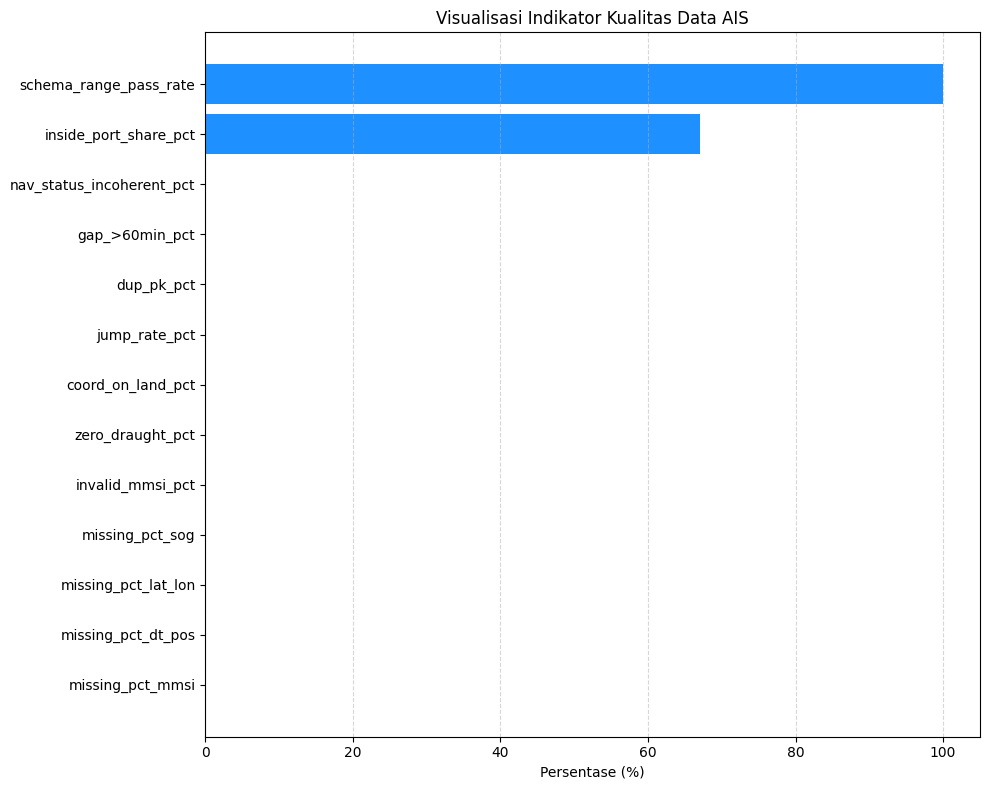

In [8]:
# Ambil hanya metrik QA yang berupa persentase atau rate
qa_plot = qa_df_full.filter(regex='pct|rate', axis=1).T
qa_plot.columns = ['value']
qa_plot = qa_plot.dropna()
qa_plot = qa_plot.sort_values(by='value', ascending=True)

# Buat plot horizontal
plt.figure(figsize=(10, 8))
plt.barh(qa_plot.index, qa_plot['value'], color='dodgerblue')
plt.xlabel('Persentase (%)')
plt.title('Visualisasi Indikator Kualitas Data AIS')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pastikan dt_insert_utc dan dt_pos_utc memiliki timezone
if df['dt_insert_utc'].dt.tz is None:
    df['dt_insert_utc'] = df['dt_insert_utc'].dt.tz_localize('UTC')

# Hitung QA
qa = {}
qa['missing_pct_mmsi'] = df['mmsi'].isna().mean() * 100
qa['missing_pct_dt_pos'] = df['dt_pos_utc'].isna().mean() * 100
qa['missing_pct_lat_lon'] = df[['latitude', 'longitude']].isna().mean().mean() * 100
qa['missing_pct_sog'] = df['sog'].isna().mean() * 100
qa['invalid_mmsi_pct'] = (~df['mmsi'].between(100_000_000, 999_999_999)).mean() * 100
qa['zero_draught_pct'] = (df['draught'] == 0).mean() * 100 if 'draught' in df.columns else None
qa['n_records'] = len(df)
qa['n_unique_mmsi'] = df['mmsi'].nunique()
qa['avg_rows_per_mmsi'] = qa['n_records'] / max(1, qa['n_unique_mmsi'])

df['weekday'] = df['dt_pos_utc'].dt.day_name()
for day in ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']:
    qa[f'weekday_{day}'] = df['weekday'].value_counts().get(day, 0)

range_mask = (
    df['latitude'].between(-90, 90) &
    df['longitude'].between(-180, 180) &
    df['sog'].between(0, 70)
)
qa['schema_range_pass_rate'] = range_mask.mean() * 100
qa['unique_h3_cells_res7'] = df['H3_int_index_7'].nunique() if 'H3_int_index_7' in df.columns else None

if 'inside_port' in df.columns:
    df['port_id'] = df['inside_port'].astype(str)
    daily_ports = df.groupby(df['dt_pos_utc'].dt.date)['port_id'].nunique()
    qa['avg_ports_covered_per_day'] = daily_ports.mean()
    qa['inside_port_share_pct'] = df['inside_port'].mean() * 100

qa['coord_on_land_pct'] = ((df['draught'] == 0) & (df['sog'] == 0)).mean() * 100 if 'draught' in df.columns else None
qa['jump_rate_pct'] = df['jump_flag'].mean() * 100 if 'jump_flag' in df.columns else None
qa['gap_>60min_pct'] = df['gap_flag'].mean() * 100 if 'gap_flag' in df.columns else None

df['sog_calc'] = df['jump_km'] / (df['dt_diff_min'] / 60)
df['speed_gap'] = abs(df['sog'] - df['sog_calc'])
qa['mean_speed_gap_knots'] = df['speed_gap'].mean()

meta_var = df.groupby('mmsi')[['imo', 'vessel_name', 'length', 'width']].nunique()
qa['meta_inconsistency_mmsi'] = (meta_var > 1).any(axis=1).sum()

df['latency'] = (df['dt_insert_utc'] - df['dt_pos_utc']).dt.total_seconds()
qa['ingest_latency_p95_sec'] = df['latency'].quantile(0.95)

dup_pk = df.duplicated(subset=['mmsi', 'dt_pos_utc'], keep=False)
qa['dup_pk_pct'] = dup_pk.mean() * 100

df['nav_incoherent'] = ((df['nav_status'].str.contains('Moored|Anchored', case=False, na=False)) & (df['sog'] > 0.5))
qa['nav_status_incoherent_pct'] = df['nav_incoherent'].mean() * 100

qa_df_all = pd.DataFrame([qa])
print(qa_df_all.T)


                                  0
missing_pct_mmsi             0.0000
missing_pct_dt_pos           0.0000
missing_pct_lat_lon          0.0000
missing_pct_sog              0.0000
invalid_mmsi_pct             0.0000
zero_draught_pct             0.0000
n_records                  100.0000
n_unique_mmsi                4.0000
avg_rows_per_mmsi           25.0000
weekday_Monday               0.0000
weekday_Tuesday              0.0000
weekday_Wednesday          100.0000
weekday_Thursday             0.0000
weekday_Friday               0.0000
weekday_Saturday             0.0000
weekday_Sunday               0.0000
schema_range_pass_rate     100.0000
unique_h3_cells_res7        25.0000
avg_ports_covered_per_day    2.0000
inside_port_share_pct       67.0000
coord_on_land_pct            0.0000
jump_rate_pct                0.0000
gap_>60min_pct               0.0000
mean_speed_gap_knots         2.7087
meta_inconsistency_mmsi      0.0000
ingest_latency_p95_sec      78.0500
dup_pk_pct                  

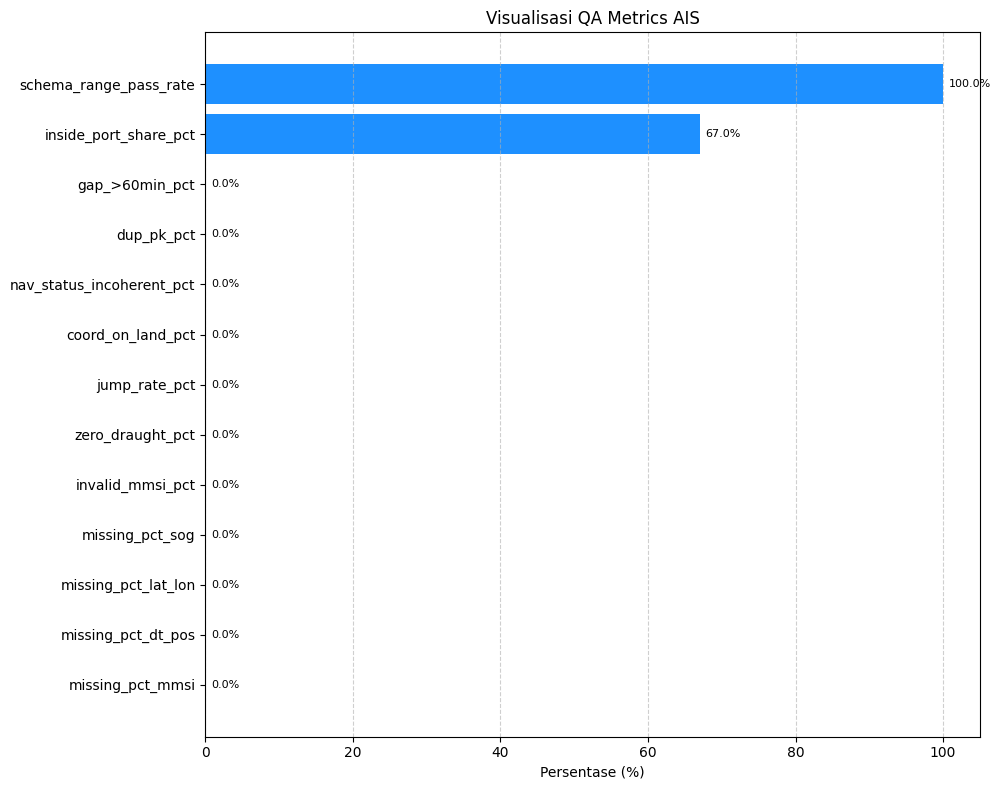

In [11]:
qa_plot = qa_df_all.filter(regex='pct|rate', axis=1).T
qa_plot.columns = ['value']
qa_plot = qa_plot.dropna()
qa_plot = qa_plot.sort_values(by='value', ascending=True)

plt.figure(figsize=(10, 8))
bars = plt.barh(qa_plot.index, qa_plot['value'], color='dodgerblue')
plt.xlabel('Persentase (%)')
plt.title('Visualisasi QA Metrics AIS')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

for bar in bars:
    plt.text(bar.get_width() + 0.8, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.1f}%', va='center', fontsize=8)

plt.show()


## Final

In [2]:
import pandas as pd
import numpy as np

df_all = pd.read_csv('sample_ais_data.csv', parse_dates=['dt_pos_utc', 'dt_insert_utc'])

# Salin data mentah
df = df_all.copy()

# 1. Konversi kolom waktu ke datetime
df['dt_pos_utc'] = pd.to_datetime(df['dt_pos_utc'], errors='coerce')
df['dt_insert_utc'] = pd.to_datetime(df['dt_insert_utc'], errors='coerce')

# 2. Validasi kelengkapan dan tipe data dasar
df = df.dropna(subset=['mmsi', 'dt_pos_utc', 'latitude', 'longitude', 'sog'])
df = df[df['mmsi'].between(100_000_000, 999_999_999)]
df = df[df['latitude'].between(-90, 90)]
df = df[df['longitude'].between(-180, 180)]

# 3. Imputasi IMO berdasarkan grup MMSI
df['imo'] = df.groupby('mmsi')['imo'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# 4. Deduplikasi berdasarkan (mmsi, dt_pos_utc, message_type)
df = df.drop_duplicates(subset=['mmsi', 'dt_pos_utc', 'message_type'])

# 5. Tandai nilai draught = 0 atau kosong (jangan dihapus)
df['draught_flag'] = (df['draught'] == 0) | (df['draught'].isna())

# 6. Tandai vessel_type bukan Cargo atau Tanker
df['vessel_type_flag'] = ~df['vessel_type'].isin(['Cargo', 'Tanker'])

# 7. Validasi nilai sog dan waktu
df = df[df['sog'].between(0, 70)]
if df['dt_pos_utc'].dt.tz is None:
    df['dt_pos_utc'] = df['dt_pos_utc'].dt.tz_localize('UTC')
df = df[df['dt_pos_utc'] <= pd.Timestamp.now(tz='UTC') + pd.Timedelta(minutes=5)]

# 8. Audit metadata per MMSI (jumlah variasi IMO, nama, panjang, lebar)
meta_flags = df.groupby('mmsi')[['imo', 'vessel_name', 'length', 'width']].nunique()
meta_inconsistent = meta_flags[(meta_flags > 1).any(axis=1)]

# 9. Hitung jarak antar titik & kecepatan loncatan (teleport check)
df = df.sort_values(by=['mmsi', 'dt_pos_utc'])
df['prev_lat'] = df.groupby('mmsi')['latitude'].shift()
df['prev_lon'] = df.groupby('mmsi')['longitude'].shift()
df['prev_time'] = df.groupby('mmsi')['dt_pos_utc'].shift()

def haversine(lat1, lon1, lat2, lon2):
    r = 6371  # radius bumi km
    lat1, lat2, lon1, lon2 = map(np.radians, [lat1, lat2, lon1, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * r * np.arcsin(np.sqrt(a))

df['jump_km'] = haversine(df['prev_lat'], df['prev_lon'], df['latitude'], df['longitude'])
df['dt_diff_min'] = (df['dt_pos_utc'] - df['prev_time']).dt.total_seconds() / 60
df['km_per_min'] = df['jump_km'] / df['dt_diff_min']
df['jump_flag'] = df['km_per_min'] > 30  # jika kecepatan loncatan > 30 km/mnt
df['gap_flag'] = df['dt_diff_min'] > 60  # jika jeda sinyal > 60 menit

# 10. Tandai titik berada di pelabuhan (placeholder: draught > 5)
df['inside_port'] = df['draught'] > 5


C:\Users\farhan\AppData\Local\Temp\ipykernel_18836\1494988161.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['imo'] = df.groupby('mmsi')['imo'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- QA Metrics dengan nama indikator ---
qa_named = []

# Helper untuk menambahkan ke list QA
def add_qa(name, desc, value):
    qa_named.append({'Indikator': name, 'Deskripsi': desc, 'Nilai': value})

# Validasi timezone
if df['dt_insert_utc'].dt.tz is None:
    df['dt_insert_utc'] = df['dt_insert_utc'].dt.tz_localize('UTC')

# 1–4. Missing
add_qa("Missing MMSI", "Percent of Missing MMSI", df['mmsi'].isna().mean() * 100)
add_qa("Missing Waktu Posisi", "Percent of Missing dt_pos_utc", df['dt_pos_utc'].isna().mean() * 100)
add_qa("Missing Koordinat", "Percent of Missing lat/lon", df[['latitude', 'longitude']].isna().mean().mean() * 100)
add_qa("Missing Kecepatan (SOG)", "Percent of Missing sog", df['sog'].isna().mean() * 100)

# 5. Invalid MMSI
add_qa("MMSI Tidak Valid", "Percent of MMSI not in 9-digit range", (~df['mmsi'].between(100_000_000, 999_999_999)).mean() * 100)

# 6. Draught 0
add_qa("Draught = 0", "Percent of draught values equal to zero", (df['draught'] == 0).mean() * 100)

# 7. Jumlah Rekor
add_qa("Jumlah Rekor", "Total number of valid AIS records", len(df))

# 8. Kapal Unik (MMSI)
add_qa("Jumlah Kapal Unik", "Number of unique MMSI", df['mmsi'].nunique())

# 9. Rata-rata Ping per Kapal
avg_ping = len(df) / max(1, df['mmsi'].nunique())
add_qa("Rata-rata Ping per Kapal", "Average AIS rows per MMSI", avg_ping)

# 10. Schema & Range Check
range_pass = (
    df['latitude'].between(-90, 90) &
    df['longitude'].between(-180, 180) &
    df['sog'].between(0, 70)
).mean() * 100
add_qa("Schema Range Pass Rate", "Baris dengan lat/lon/sog dalam batas normal", range_pass)

# 11. Unique H3 Cells (res7)
if 'H3_int_index_7' in df.columns:
    add_qa("Cakupan Sel H3 (res7)", "Jumlah sel H3 unik resolusi 7", df['H3_int_index_7'].nunique())

# 12. Port Harian (dummy: inside_port)
if 'inside_port' in df.columns:
    df['port_id'] = df['inside_port'].astype(str)
    daily_ports = df.groupby(df['dt_pos_utc'].dt.date)['port_id'].nunique()
    add_qa("Pelabuhan Tercover per Hari", "Rata-rata pelabuhan terdeteksi per hari", daily_ports.mean())
    add_qa("Inside-Port Share", "Proporsi titik berada di pelabuhan", df['inside_port'].mean() * 100)

# 13. Lokasi Salah (dummy: draught=0 & sog=0)
if 'draught' in df.columns:
    land_mask = ((df['draught'] == 0) & (df['sog'] == 0)).mean() * 100
    add_qa("Koordinat Tidak Masuk Akal", "Draught=0 dan sog=0", land_mask)

# 14. Teleport Detected (Jump)
if 'jump_flag' in df.columns:
    add_qa("Teleport (Jump > 30km/min)", "Persentase baris loncatan spasial", df['jump_flag'].mean() * 100)

# 15. Time Gap > 60 min
if 'gap_flag' in df.columns:
    add_qa("Gap Sinyal > 60 menit", "Persentase jeda antar ping terlalu lama", df['gap_flag'].mean() * 100)

# 16. Konsistensi Kecepatan Hitung
df['sog_calc'] = df['jump_km'] / (df['dt_diff_min'] / 60)
df['speed_gap'] = abs(df['sog'] - df['sog_calc'])
add_qa("Gap SOG vs Perhitungan", "Rata-rata selisih kecepatan asli vs hitung", df['speed_gap'].mean())

# 17. Metadata Konflik
meta_var = df.groupby('mmsi')[['imo', 'vessel_name', 'length', 'width']].nunique()
conflict_count = (meta_var > 1).any(axis=1).sum()
add_qa("Konflik Metadata Kapal", "Jumlah MMSI dengan metadata berubah-ubah", conflict_count)

# 18. Ingest Latency p95
df['latency'] = (df['dt_insert_utc'] - df['dt_pos_utc']).dt.total_seconds()
add_qa("Ingest Latency p95", "95th percentile latency (detik)", df['latency'].quantile(0.95))

# 19. Duplicate Primary Key
dup_pk = df.duplicated(subset=['mmsi', 'dt_pos_utc'], keep=False)
add_qa("Duplikat PK", "Persentase baris dengan PK ganda", dup_pk.mean() * 100)

# 20. Nav-Status Tidak Konsisten
df['nav_incoherent'] = ((df['nav_status'].str.contains('Moored|Anchored', case=False, na=False)) & (df['sog'] > 0.5))
add_qa("NavStatus ≠ SOG", "Persentase 'moored' tapi sog > 0.5", df['nav_incoherent'].mean() * 100)

# Buat DataFrame QA
qa_named_df = pd.DataFrame(qa_named)


In [4]:
!pip install ace_tools


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\farhan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
print(qa_named_df.to_string(index=False))

                  Indikator                                   Deskripsi    Nilai
               Missing MMSI                     Percent of Missing MMSI   0.0000
       Missing Waktu Posisi               Percent of Missing dt_pos_utc   0.0000
          Missing Koordinat                  Percent of Missing lat/lon   0.0000
    Missing Kecepatan (SOG)                      Percent of Missing sog   0.0000
           MMSI Tidak Valid        Percent of MMSI not in 9-digit range   0.0000
                Draught = 0     Percent of draught values equal to zero   0.0000
               Jumlah Rekor           Total number of valid AIS records 100.0000
          Jumlah Kapal Unik                       Number of unique MMSI   4.0000
   Rata-rata Ping per Kapal                   Average AIS rows per MMSI  25.0000
     Schema Range Pass Rate Baris dengan lat/lon/sog dalam batas normal 100.0000
      Cakupan Sel H3 (res7)               Jumlah sel H3 unik resolusi 7  25.0000
Pelabuhan Tercover per Hari 

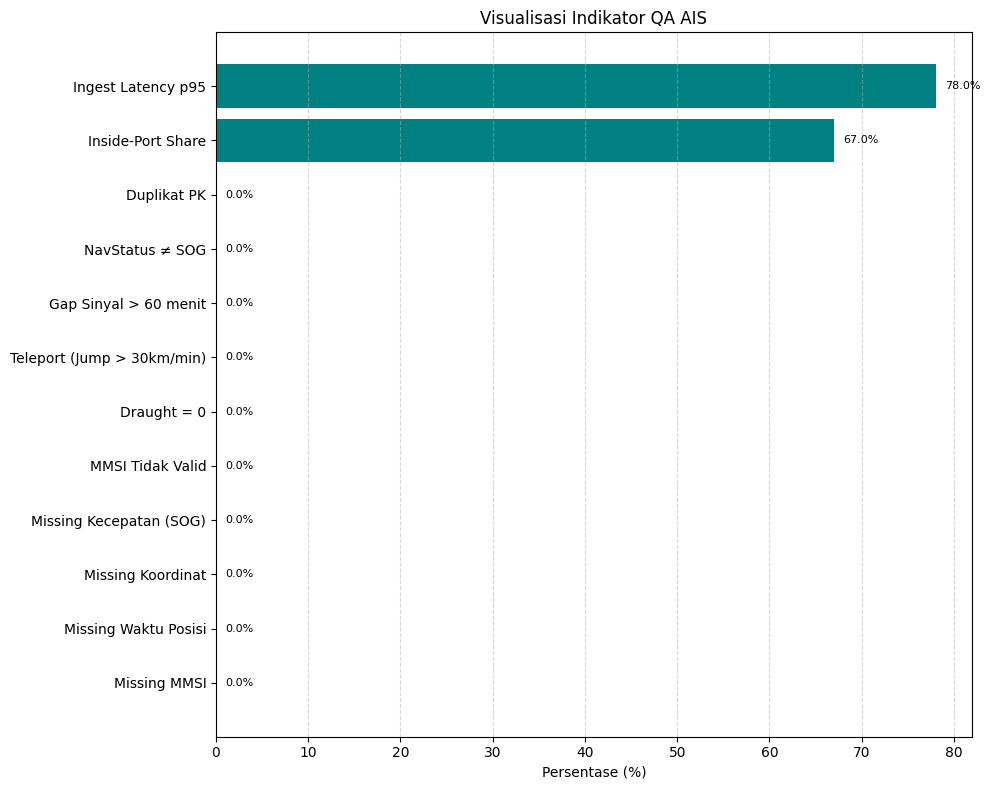

In [ ]:
# Ambil hanya metrik persentase
qa_plot = qa_named_df[qa_named_df['Deskripsi'].str.contains('Persentase|percent|proporsi|proportion|rate', case=False)]
qa_plot = qa_plot.sort_values(by='Nilai', ascending=True)

# Visualisasi bar chart horizontal
plt.figure(figsize=(10, 8))
bars = plt.barh(qa_plot['Indikator'], qa_plot['Nilai'], color='teal')
plt.xlabel('Persentase (%)')
plt.title('Visualisasi Indikator QA AIS')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Tambahkan label nilai di ujung bar
for bar in bars:
    plt.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.1f}%", va='center', fontsize=8)

plt.tight_layout()
plt.show()